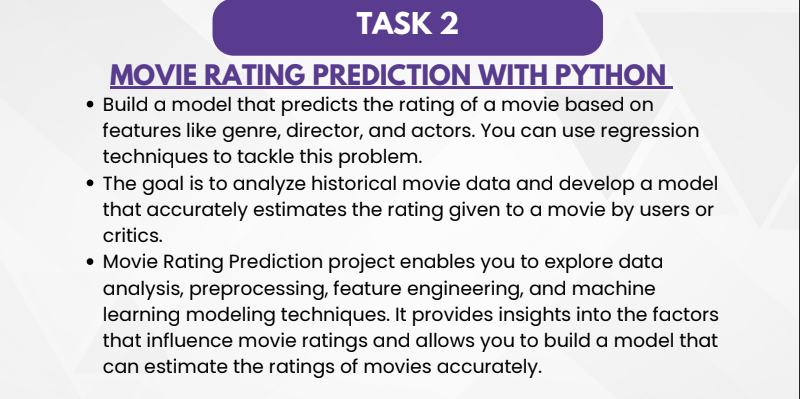

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Data Collection:

**Read the Data**

In [2]:
df = pd.read_csv("IMDb Movies India.csv", encoding='latin-1')

# 2. Preprocessing:

**Explore the Data**

In [3]:
df.shape

(15509, 10)

In [4]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [6]:
df.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

**Handle missing values**

In [7]:
df['Duration'] = df['Duration'].str.replace('min', '').apply(pd.to_numeric)
df["Votes"] = df["Votes"].replace("$5.16M", 516)
df["Votes"] = pd.to_numeric(df['Votes'].str.replace(',', ''))

# Dropping null values
df.dropna(subset=['Year'], inplace=True)
df.dropna(subset=['Genre'], inplace=True)

# Replacing Null Values ....
df['Rating'].fillna(df['Rating'].mode().max(), inplace=True)
df['Duration'].fillna(df['Duration'].mean(), inplace=True)
df['Votes'].fillna(df['Votes'].mean(), inplace=True)
df.dropna(subset=['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], inplace=True)

In [8]:
#Checking Null Values again for confirmation.
print('Null Values in Year Column',df['Year'].isnull().sum())
print('Null Values in Genre Column',df['Genre'].isnull().sum())

Null Values in Year Column 0
Null Values in Genre Column 0


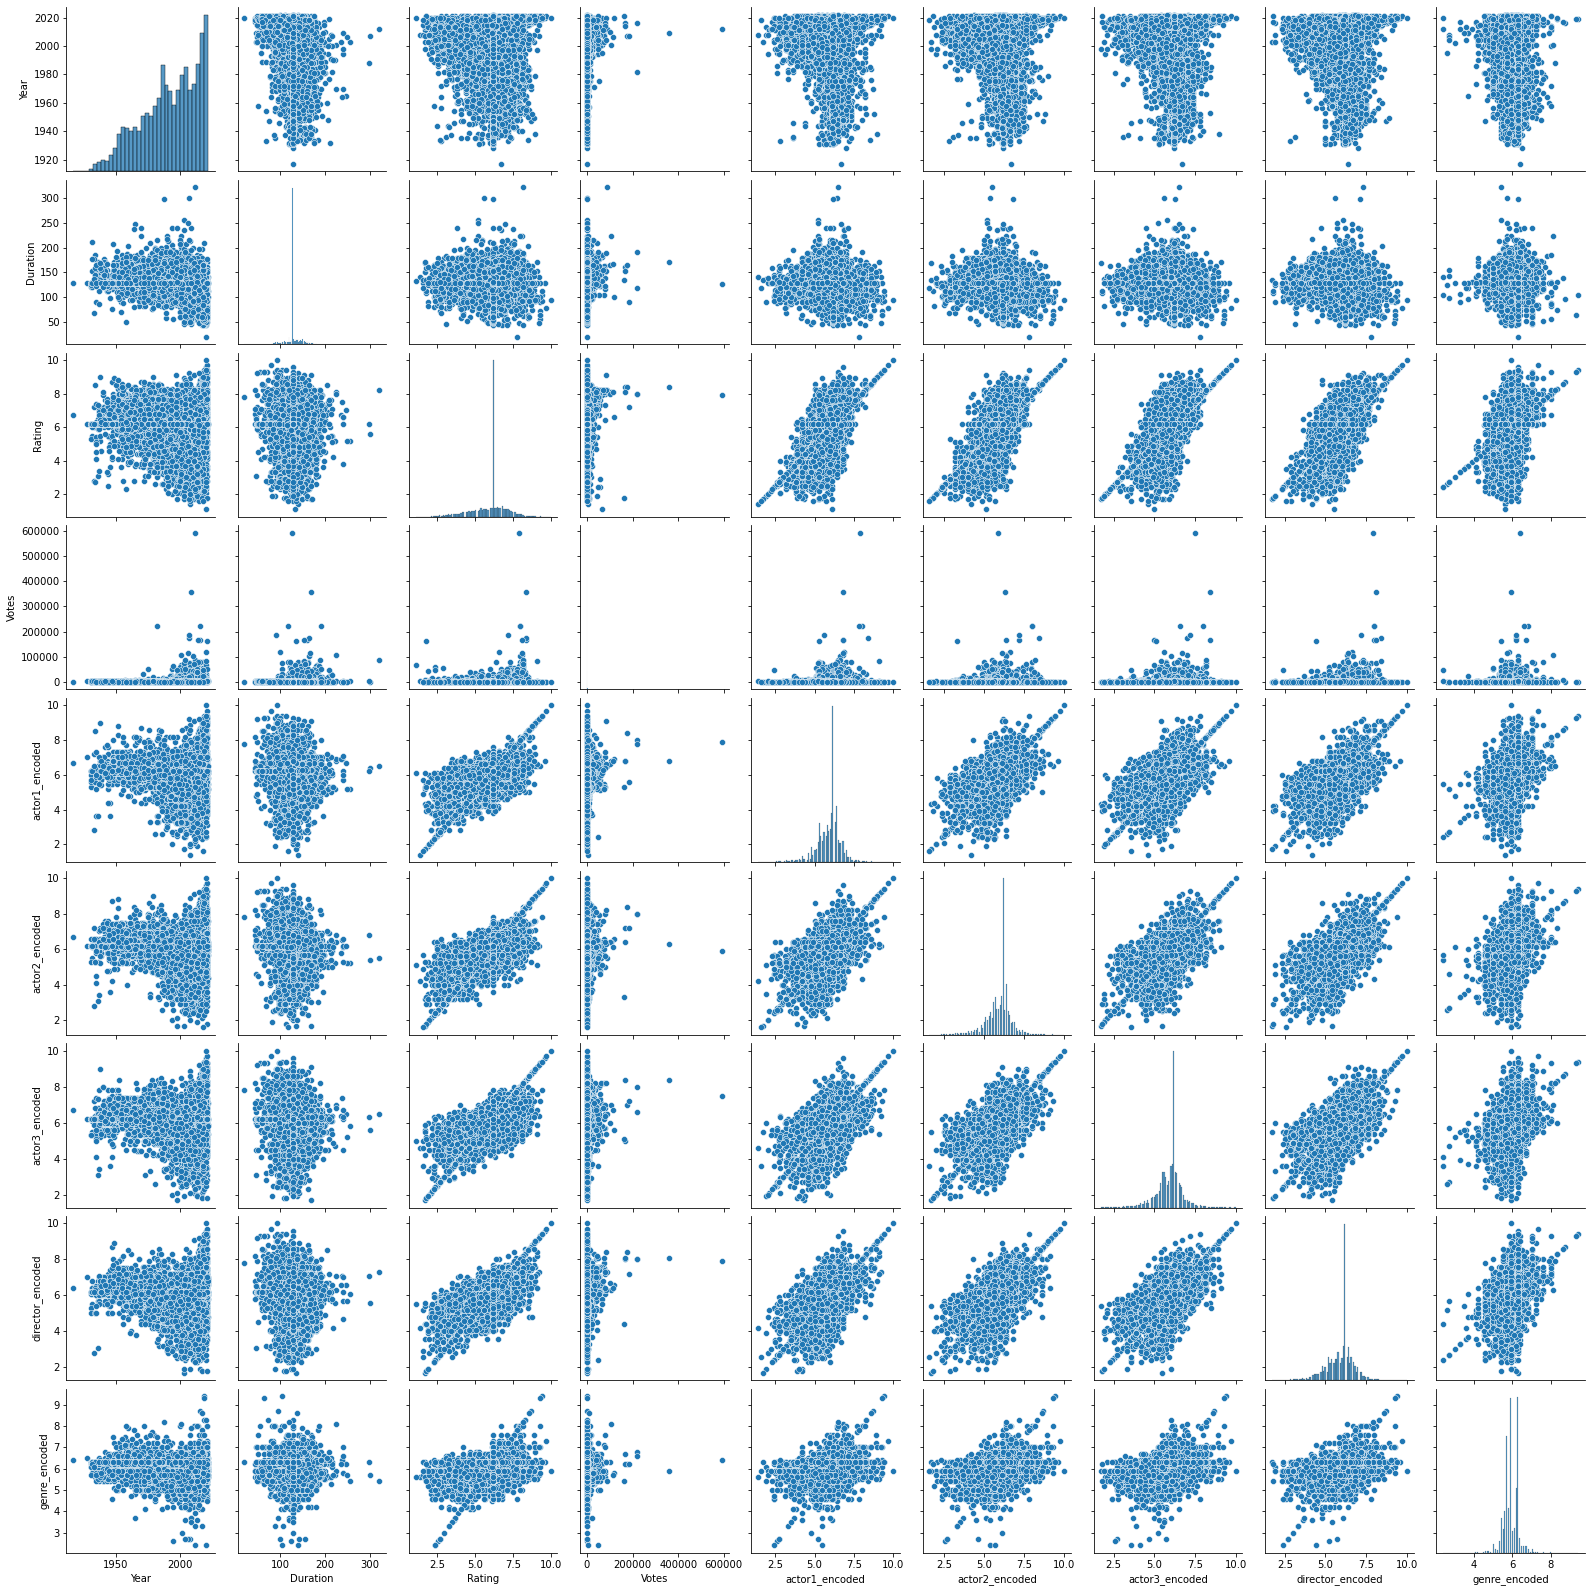

In [16]:
sns.pairplot(df)
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr(method='spearman')

# Model Deployment

In [9]:
non_numeric_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
print(non_numeric_columns)

Index(['Name', 'Year', 'Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], dtype='object')


In [10]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr(method='spearman')
print(df.columns)

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')


In [11]:
df.dropna(subset=['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], inplace=True)
(round(df.isnull().sum()/df.isnull().count(), 4)*100).sort_values(ascending=False)

Actor 3     0.0
Actor 2     0.0
Actor 1     0.0
Director    0.0
Votes       0.0
Rating      0.0
Genre       0.0
Duration    0.0
Year        0.0
Name        0.0
dtype: float64

In [12]:
# Extracting the numeric part from the 'Year' column
df['Year'] = df['Year'].str.extract('(\d+)').astype(float)

# Encoding categorical variables based on mean ratings
actor1_encoding_map = df.groupby('Actor 1').agg({'Rating': 'mean'}).to_dict()['Rating']
actor2_encoding_map = df.groupby('Actor 2').agg({'Rating': 'mean'}).to_dict()['Rating']
actor3_encoding_map = df.groupby('Actor 3').agg({'Rating': 'mean'}).to_dict()['Rating']
director_encoding_map = df.groupby('Director').agg({'Rating': 'mean'}).to_dict()['Rating']
genre_encoding_map = df.groupby('Genre').agg({'Rating': 'mean'}).to_dict()['Rating']

df['actor1_encoded'] = round(df['Actor 1'].map(actor1_encoding_map), 1)
df['actor2_encoded'] = round(df['Actor 2'].map(actor2_encoding_map), 1)
df['actor3_encoded'] = round(df['Actor 3'].map(actor3_encoding_map), 1)
df['director_encoded'] = round(df['Director'].map(director_encoding_map), 1)
df['genre_encoded'] = round(df['Genre'].map(genre_encoding_map), 1)
# Drop original categorical columns
df.drop(['Actor 1', 'Actor 2', 'Actor 3', 'Director', 'Genre'], axis=1, inplace=True)

# Define features and target variable
X = df[['Year', 'Duration', 'Votes', 'actor1_encoded', 'actor2_encoded', 'actor3_encoded', 'director_encoded', 'genre_encoded']]
y = df['Rating']


**Split data into train and test sets**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model Building - Linear Regression**

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

**Model Building - Random Forest Regressor**

In [14]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Evaluat Model

In [19]:
# Evaluate Linear Regression
print('Linear Regression Metrics:')
print('Mean Squared Error:', mean_squared_error(y_test, lr_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, lr_pred))
print('R2 Score:', r2_score(y_test, lr_pred))

# Evaluate Random Forest Regressor
print('\nRandom Forest Regressor Metrics:')
print('Mean Squared Error:', mean_squared_error(y_test, rf_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, rf_pred))
print('R2 Score:', r2_score(y_test, rf_pred))

Linear Regression Metrics:
Mean Squared Error: 0.3665888506799682
Mean Absolute Error: 0.42989188132758405
R2 Score: 0.7225368077510115

Random Forest Regressor Metrics:
Mean Squared Error: 0.26421811406672674
Mean Absolute Error: 0.30204733994590205
R2 Score: 0.8000190097353461


# Visualization of Model Predictions

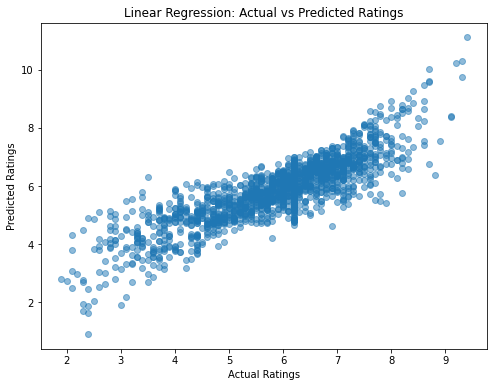

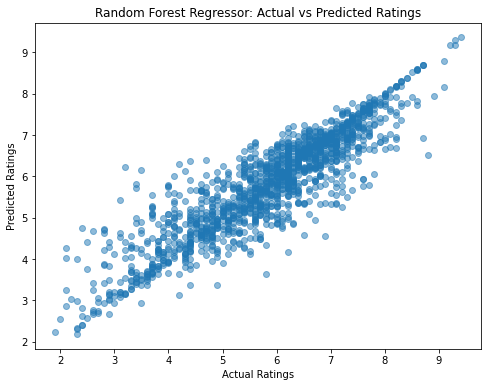

In [20]:
# Scatter plot for Linear Regression predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.title('Linear Regression: Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

# Scatter plot for Random Forest Regressor predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.title('Random Forest Regressor: Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()